# Exploration.14 - 영화 추천 시스템 만들기

## 사전 지식

### 1. 용어
- 추천 시스템 : 사용자가 선호할 만한 아이템을 추측함으로써 여러 가지 항목 중 사용자에게 적합한 특정 항목을 선택(information filtering)하여 제공하는 시스템

- 필터링 : 여러 가지 항목 중 적당한 항목을 선택하는 기술을 말하는 IT 용어

- 추천 알고리즘
    - 추천 시스템은 정보를 추려서(filtering) 사용자에게 제공
    - 다시 말하면 사용자가 전체 정보를 볼 기회를 박탈당할 수도 있음

- 필터버블
    - 추천 시스템이 고도화될수록 사용자의 입맛에 맞는 정보만 제공되고 나머지 정보는 감추어지는 위험이 발생

### 2. 추천 시스템 종류
- 협업필터링(Collaborative filtering)
    - 협업 필터링이란 대규모의 기존 사용자 행동 정보를 분석
    - 해당 사용자와 비슷한 성향의 사용자들이 기존에 좋아했던 항목을 추천하는 기술  
    (가장 일반적인 예는 온라인 쇼핑 사이트에서 흔히 볼 수 있는 ‘이 상품을 구매한 사용자가 구매한 상품들’ 서비스)
    - 비슷한 패턴을 가진 사용자나 항목을 추출하는 기술이 핵심
    - 방법
        - 행렬분해(Matrix Factorization)
        - k-최근접 이웃 알고리즘 (k-Nearest Neighbor algorithm, kNN)
    - 문제점
        - 콜드 스타트(Cold Start)
            - 기존에 없던 새로운 항목이 추가되는 경우는 추천이 곤란
        - 계산량이 비교적 많은 알고리즘이므로 사용자 수가 많은 경우 효율적으로 추천할 수 없음
            - 행렬분해의 경우, 사용자 수가 커짐에 따라 계산이 몇 시간에서 며칠까지 걸리는 경우가 종종 생김
        - 롱테일(Long tail)
            - 시스템 항목이 많다 하더라도 사용자들은 소수의 인기 있는 항목에만 관심을 보임
            - 사용자들의 관심이 적은 다수의 항목은 추천을 위한 충분한 정보를 제공하지 못함
<br><br>

- 콘텐츠 기반 필터링 (Content-based filtering)
    - 항목을 분석한 프로파일(item profile)과 사용자의 선호도를 추출한 프로파일(user profile)을 추출하여 이의 유사성을 계산  
    (음악을 추천하기 위해 음악 자체를 분석하여 유사한 음악을 추천하는 방식)
    - 콘텐츠의 내용을 분석해야 하므로 아이템 분석 알고리즘이 핵심
    - 방법
        - 군집분석(Clustering analysis)
        - 인공신경망(Artificial neural network)
        - tf-idf(term frequency-inverse document frequency)
    - 문제점
        - 다양한 형식의 항목을 추천하기 어려움
        - 음악과 사진, 비디오를 동시에 추천해야 하는 경우, 각각의 항목에서 얻을 수 있는 정보가 달라 프로파일을 구성하기 매우 어려움 
<br><br>
- http://www.kocca.kr/insight/vol05/vol05_04.pdf

### 3. 암묵적 피드백 (Implicit-feedback)
- 사용자의 아이템 선호도를 말해 주는 유저 행동 데이터셋이 없는 경우  
- 특징
    - 부정적인 피드백이 없음 (No Negative Feedback)
    - 애초에 잡음이 많음 (Inherently Noisy)
    - 수치는 신뢰도를 의미함 (The numerical value of implicit feedback indicates confidence)
    - 평가는 적절한 방법을 고민해봐야 함 (Evaluation of implicit-feedback recommender requires appropriate measures)

## 데이터 불러오기

### 1. 유저에 따른 영화 데이터 불러오기

In [1]:
import pandas as pd
import os

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'counts', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


- 'counts'에 해당하는 것은 원래 별점임
- 암묵적 평가를 위해 별점 대신 'counts'(시청횟수)로 간주하고 문제를 풀어갈 예정

In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['counts']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


- 시청 횟수 3회 미만은 선호하지 않는다고 간주하고 제외함

- 3회 미만을 제외한 데이터 사이즈 : 836,478  
    - 제외 전 : 1,000,209
    - 83.63%의 데이터가 제외되지 않고 남음

In [3]:
# 유저 수
ratings['user_id'].nunique()

6039

- 총 유저 수는 6,040명

In [4]:
ratings['movie_id'].nunique()

3628

- 유저들이 3회 이상 본 영화 수 : 3,706편

### 2. 영화 데이터 불러오기

In [5]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies['movie_id'].nunique()

3883

### 3. 영화 제목 소문자로 변경하기

- 전체 데이터에 있는 총 영화 수 : 3,883편

In [7]:
movies['title'] = movies['title'].str.lower()

### 4. 데이터 합치기

In [8]:
df = pd.merge(ratings, movies, how='left', on='movie_id')
df.head()

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,one flew over the cuckoo's nest (1975),Drama
1,1,661,3,978302109,james and the giant peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,my fair lady (1964),Musical|Romance
3,1,3408,4,978300275,erin brockovich (2000),Drama
4,1,2355,5,978824291,"bug's life, a (1998)",Animation|Children's|Comedy


### 5. 필요없는 데이터 없애기

In [9]:
df = df.drop(['timestamp'], axis=1)

In [10]:
df.head()

,user_id,movie_id,counts,title,genre
0,1,1193,5,one flew over the cuckoo's nest (1975),Drama
1,1,661,3,james and the giant peach (1996),Animation|Children's|Musical
2,1,914,3,my fair lady (1964),Musical|Romance
3,1,3408,4,erin brockovich (2000),Drama
4,1,2355,5,"bug's life, a (1998)",Animation|Children's|Comedy


- 필요없다고 판단되는 'timestamp'를 제거함

## 데이터 살펴보기

### 1. 결측치 확인

In [11]:
df.isnull().sum()

user_id     0
movie_id    0
counts      0
title       0
genre       0
dtype: int64

- 결측치는 없음

### 2. 중복 확인

In [12]:
movies[movies.duplicated('movie_id')]

,movie_id,title,genre


In [13]:
movies[movies.duplicated('title')]

,movie_id,title,genre


- 영화에 관한 데이터 중 'movie_id'와 'title'이 중복으로 기입된 것은 없음

### 3. 통계

In [14]:
# 유저별 몇 편의 영화를 봤는지에 대한 통계
user_count = df.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

- 유저들은 평균 166편의 영화를 봄
- 가장 영화를 조금 본 유저는 20편의 영화를 봄
- 가장 영화를 많이 본 유저는 2,314편의 영화를 봄

In [15]:
# 유저별 각 영화 시청 횟수 평균에 대한 통계
user_mean = df.groupby('user_id')['counts'].mean()
user_mean.describe()

count    6039.000000
mean        4.025078
std         0.275632
min         3.000000
25%         3.833333
50%         4.023622
75%         4.212225
max         5.000000
Name: counts, dtype: float64

- 유저들은 평균 한 영화를 3.7회 시청함
- 각각의 한 영화를 가장 조금 본 유저는 평균 약 1번씩 시청함
- 각각의 한 영화를 가장 많이 본 유저는 평균 약 5번씩 시청함

### 4. 유저들이 가장 많이 본 영화 30위

In [16]:
favorite_movie = df.groupby('title')['user_id'].count()
favorite_movie_top30 = favorite_movie.sort_values(ascending=False).head(30)

In [17]:
favorite_movie_top30

title
american beauty (1999)                                   3211
star wars: episode iv - a new hope (1977)                2910
star wars: episode v - the empire strikes back (1980)    2885
star wars: episode vi - return of the jedi (1983)        2716
saving private ryan (1998)                               2561
terminator 2: judgment day (1991)                        2509
silence of the lambs, the (1991)                         2498
raiders of the lost ark (1981)                           2473
back to the future (1985)                                2460
matrix, the (1999)                                       2434
jurassic park (1993)                                     2413
sixth sense, the (1999)                                  2385
fargo (1996)                                             2371
braveheart (1995)                                        2314
men in black (1997)                                      2297
schindler's list (1993)                                  2257
pr

- 유저들이 가장 많이 본 영화 1위는 'American Beauty'로 3,428명이 시청함

### 5. 총 시청횟수가 가장 많은 영화 30위

In [18]:
favorite_movie_sum_view = df.groupby('title')['counts'].sum()
favorite_movie_sum_view_top30 = favorite_movie_sum_view.sort_values(ascending=False).head(30)

In [19]:
favorite_movie_sum_view_top30

title
american beauty (1999)                                   14449
star wars: episode iv - a new hope (1977)                13178
star wars: episode v - the empire strikes back (1980)    12648
saving private ryan (1998)                               11348
star wars: episode vi - return of the jedi (1983)        11303
raiders of the lost ark (1981)                           11179
silence of the lambs, the (1991)                         11096
matrix, the (1999)                                       10903
sixth sense, the (1999)                                  10703
terminator 2: judgment day (1991)                        10513
fargo (1996)                                             10465
schindler's list (1993)                                  10317
braveheart (1995)                                        10125
shawshank redemption, the (1994)                         10085
back to the future (1985)                                10081
godfather, the (1972)                            

- 총 시청수가 가장 많은 영화는 'American Beauty'로 전체 유저에서 총 14,800번 시청함

## 데이터 추가하기

### 1. 선호하는 영화 5개 정보 추출
- 영화 풀네임을 정확히 검색하기 어려움
- .str.contains()를 통해 원하는 영화명을 찾을 예정
- **기존 데이터에 없는 영화 정보를 추가하여 비교해 볼 예정**
    - 

In [20]:
movies[movies['title'].str.contains('lion')]

,movie_id,title,genre
360,364,"lion king, the (1994)",Animation|Children's|Musical
1980,2049,"happiest millionaire, the (1967)",Comedy|Musical


In [21]:
movies[movies['title'].str.contains('matrix')]

,movie_id,title,genre
2502,2571,"matrix, the (1999)",Action|Sci-Fi|Thriller


In [22]:
movies[movies['title'].str.contains('toy')]

,movie_id,title,genre
0,1,toy story (1995),Animation|Children's|Comedy
1948,2017,babes in toyland (1961),Children's|Fantasy|Musical
2184,2253,toys (1992),Action|Comedy|Fantasy
2411,2480,dry cleaning (nettoyage à sec) (1997),Drama
3017,3086,march of the wooden soldiers (a.k.a. laurel & ...,Comedy
3045,3114,toy story 2 (1999),Animation|Children's|Comedy


In [23]:
movies[movies['title'].str.contains('hercules')]

,movie_id,title,genre
1526,1566,hercules (1997),Adventure|Animation|Children's|Comedy|Musical


In [24]:
movies[movies['title'].str.contains('million')]

,movie_id,title,genre
1980,2049,"happiest millionaire, the (1967)",Comedy|Musical


- 'Million Dollar Baby'를 넣고 싶었지만 기존 항목에 없어서 추가할 예정

### 2. 좋아하는 영화를 데이터프레임에 추가하기

In [25]:
my_favorite = ['lion king, the (1994)' , 'matrix, the (1999)' ,'toy story (1995)' ,'hercules (1997)', 'million dollar baby']

# 'ktw'이라는 user_id가 위 영화를 5회씩 봤다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['ktw']*5, 'title': my_favorite, 'counts':[5]*5})

if not df.isin({'user_id':['ktw']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    df = df.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

df.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,counts,title,genre
836473,6040,1090.0,3,platoon (1986),Drama|War
836474,6040,1094.0,5,"crying game, the (1992)",Drama|Romance|War
836475,6040,562.0,5,welcome to the dollhouse (1995),Comedy|Drama
836476,6040,1096.0,4,sophie's choice (1982),Drama
836477,6040,1097.0,4,e.t. the extra-terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
0,ktw,NaN,5,"lion king, the (1994)",NaN
1,ktw,NaN,5,"matrix, the (1999)",NaN
2,ktw,NaN,5,toy story (1995),NaN
3,ktw,NaN,5,hercules (1997),NaN
4,ktw,NaN,5,million dollar baby,NaN


### 3. movies에 'million dollar baby' 정보 추가하기
- 'million dollar baby'는 원래 데이터에 없던 영화임
- 결측치에 대한 내용을 추가할 예정

In [26]:
movies.tail()

,movie_id,title,genre
3878,3948,meet the parents (2000),Comedy
3879,3949,requiem for a dream (2000),Drama
3880,3950,tigerland (2000),Drama
3881,3951,two family house (2000),Drama
3882,3952,"contender, the (2000)",Drama|Thriller


In [27]:
movies['movie_id'].max()

3952

- moives의 가장 큰 movie_id는 3,952임
- 'million dollar baby'를 movie_id는 3,953으로 지정하려고 함

In [28]:
movies[movies['movie_id'] == 3953]

,movie_id,title,genre


- 현재 movie_id는 3,953인 영화는 없음

In [29]:
million_dollar = {'movie_id':3953, 'title':'million dollar baby', 'genre':'Drama'}

In [30]:
movies = movies.append(million_dollar, ignore_index=True)

In [31]:
movies.tail()

,movie_id,title,genre
3879,3949,requiem for a dream (2000),Drama
3880,3950,tigerland (2000),Drama
3881,3951,two family house (2000),Drama
3882,3952,"contender, the (2000)",Drama|Thriller
3883,3953,million dollar baby,Drama


- 'million dollar baby'를 movies에 추가함

### 4. 결측치에 대한 정보 넣기

In [32]:
df[(df['user_id'] == 'ktw') & (df['title'] == 'lion king, the (1994)')]['movie_id']

0   NaN
Name: movie_id, dtype: float64

In [33]:
movies.loc[movies['title'] == 'lion king, the (1994)', 'movie_id']

360    364
Name: movie_id, dtype: int64

In [34]:
movies.loc[movies['title'] == 'lion king, the (1994)', 'movie_id'].values

array([364])

- .values 로 해당 값만 가져옴

In [35]:
df.loc[(df['user_id'] == 'ktw') & (df['title'] == 'lion king, the (1994)'), 'movie_id'] = movies.loc[movies['title'] == 'lion king, the (1994)', 'movie_id'].values

In [36]:
df[(df['user_id'] == 'ktw') & (df['title'] == 'lion king, the (1994)')]['movie_id']

0    364.0
Name: movie_id, dtype: float64

- 시험삼아 'lion king'에 대한 'moive_id' 추가
- 잘 추가된 것을 확인함

In [37]:
temp_lst = ['matrix, the (1999)', 'toy story (1995)', 'hercules (1997)', 'million dollar baby']

In [38]:
for i in temp_lst:
    df.loc[(df['user_id'] == 'ktw') & (df['title'] == i), 'movie_id'] = movies.loc[movies['title'] == i, 'movie_id'].values

In [39]:
df.tail(10) 

,user_id,movie_id,counts,title,genre
836473,6040,1090.0,3,platoon (1986),Drama|War
836474,6040,1094.0,5,"crying game, the (1992)",Drama|Romance|War
836475,6040,562.0,5,welcome to the dollhouse (1995),Comedy|Drama
836476,6040,1096.0,4,sophie's choice (1982),Drama
836477,6040,1097.0,4,e.t. the extra-terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
0,ktw,364.0,5,"lion king, the (1994)",NaN
1,ktw,2571.0,5,"matrix, the (1999)",NaN
2,ktw,1.0,5,toy story (1995),NaN
3,ktw,1566.0,5,hercules (1997),NaN
4,ktw,3953.0,5,million dollar baby,NaN


### 5. movie_id를 기존 형태인 int로 바꾸기

In [40]:
df['movie_id'] = df['movie_id'].astype(int)
df.tail()

,user_id,movie_id,counts,title,genre
0,ktw,364,5,"lion king, the (1994)",NaN
1,ktw,2571,5,"matrix, the (1999)",NaN
2,ktw,1,5,toy story (1995),NaN
3,ktw,1566,5,hercules (1997),NaN
4,ktw,3953,5,million dollar baby,NaN


##  CSR matrix

- Sparse Matrix
    - 유저 수 X 영화 수만큼 행렬 계산을 했을 때
        - 유저가 보지 않은 영화에 대한 정보까지 모두 행렬에 포함되어 계산
        - 평가행렬 내에는 유저가 안 본 영화가 대부분이기 때문에 0으로 채워진 공간이 많아짐
    - 메모리 낭비가 심함

- CSR Matrix
    - Sparse matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성
    - 메모리 사용량을 최소화
    - Sparse matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조
    - data, indices, indptr 로 행렬을 압축하여 표현

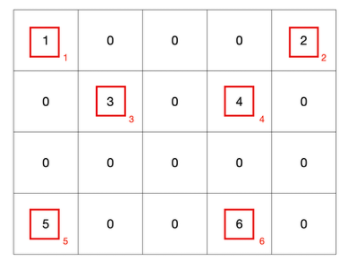

- data : 0이 아닌 원소를 차례로 기입한 값
    - data = [1, 2, 3, 4, 5, 6]
<br><br>
- indices : data의 각 요소가 어느 열(column)에 있는지를 표현한 index
    - indices = [0, 4, 1, 3, 0, 3]
    - 첫 번째 열에서의 data index : 0, 4
    - 두 번째 열에서의 data index : 1, 3
<br><br>
- indptr : 각 행(row)에서 0이 아닌 첫 번째 원소가 data 리스트에서의 몇 번째에 해당하는지와 마지막에 data 벡터의 길이를 추가한 값
    - indptr = [0, 2, 4, 4, 6]
    - 0 : 첫번째 행의 첫번째 0이 아닌 값의 전체 데이터에서의 인덱스
    - 2 : 두번재 행의 첫번째 0이 아닌 값의 전체 데이터에서의 인덱스
    - 6 : 0이 아닌 데이터의 갯수
<br><br>
- data[0:2]는 첫 번째 행, data[2:4]는 두 번째 행, data[4:4]는 세 번째 행, data[4:6]는 네 번째 행에 위치함을 나타낼 수 있음

### 1. indexing
- 새로 추가한 user_id인 'ktw'는 문자열이므로 정수형으로 변환 필요
- 관리하기 편하도록 정수로 변환 필요
- user_id와 title을 인덱싱할 예정

In [41]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = df['user_id'].unique()
moive_unique = df['title'].unique()

# 유저, 영화 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(moive_unique)}

In [42]:
print(user_to_idx['ktw']) 

6039


In [43]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = df['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(df):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    df['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = df['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(df):
    print('title column indexing OK!!')
    df['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

user_id column indexing OK!!
title column indexing OK!!


In [44]:
df.tail()

,user_id,movie_id,counts,title,genre
0,6039,364,5,330,NaN
1,6039,2571,5,124,NaN
2,6039,1,5,40,NaN
3,6039,1566,5,32,NaN
4,6039,3953,5,3628,NaN


### 2. CSR matrix 만들기

In [45]:
from scipy.sparse import csr_matrix

num_user = df['user_id'].nunique()
num_movie = df['title'].nunique()

csr_data = csr_matrix((df.counts, (df.user_id, df.title)), shape= (num_user, num_movie))
csr_data

<6040x3629 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

## AlternatingLeastSquares 모델

### 1. 모델 선언

In [46]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [47]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지
1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.

### 2. 입력 형태 맞추기

In [48]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3629x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

### 3. 모델 학습

In [49]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

## 학습 확인

### 1. 벡터 변환 확인
- ktw(user_id)와 million dollar baby(title)의 벡터 변환을 확인할 예정

In [50]:
ktw, million_dollar, lion_king = user_to_idx['ktw'], movie_to_idx['million dollar baby'], movie_to_idx['lion king, the (1994)']
ktw_vector, million_dollar_vector, lion_king_vector = als_model.user_factors[ktw], als_model.item_factors[million_dollar], als_model.item_factors[lion_king]

In [51]:
ktw_vector

array([ 0.33359233,  0.2643448 ,  0.21811873, -0.99354905,  0.87071365,
        0.12501141,  0.5532534 , -0.01834329,  0.34193787,  0.04410231,
       -0.5924143 ,  0.94037634, -0.2789585 , -0.15194672, -0.23645857,
       -0.23301189,  0.33272603,  0.03451527, -0.94368696,  0.8045294 ,
       -0.7470223 ,  0.142916  , -0.3093962 , -0.5101821 ,  0.63034385,
       -0.17040202,  0.44444436, -0.78429043, -0.13622575,  0.06699647,
        0.58611107,  0.43812126,  0.33869976, -0.2673672 , -0.3561182 ,
       -0.5145375 , -0.283657  , -0.3772254 , -0.4490324 ,  0.02629614,
       -0.27704018, -0.05335082,  0.09340529, -0.32450342,  0.47076994,
        0.4293107 ,  0.39500952, -0.8114822 ,  0.33405927,  0.9074672 ,
        0.392354  ,  0.07353829, -0.41643086, -0.3673198 , -0.30774114,
        0.27212226,  0.16110013,  0.22850645,  0.21239524,  0.07287802,
       -0.88868594, -0.78090775, -0.44765988, -0.31383398,  0.5816907 ,
       -0.2645656 , -0.49543434,  0.11052037,  0.3126668 ,  0.04

In [52]:
million_dollar_vector

array([ 5.06059150e-04,  1.23229134e-03,  5.44828246e-04,  2.10355342e-04,
        8.03769915e-04, -2.01600924e-04,  1.14523864e-03,  6.33082411e-04,
        3.36829893e-04,  7.56690570e-04,  8.43424757e-04,  5.09394973e-04,
        9.59124081e-05,  4.33393434e-04,  7.32950051e-04,  6.15410157e-04,
        2.73315760e-04,  6.85599749e-04, -2.32677892e-04,  1.15038338e-03,
       -7.45423749e-05,  6.72342256e-04,  2.50890793e-04,  1.66815560e-04,
        6.95063558e-04,  9.06780479e-04,  1.00884552e-03, -9.21051978e-05,
        3.31726478e-04, -1.56101363e-04,  5.46448166e-04,  2.07721256e-04,
        5.21749433e-04,  3.31374002e-04,  3.97564727e-04,  8.58937346e-05,
        2.73123180e-04,  1.07674277e-03, -3.21796630e-04,  4.70148894e-04,
        1.80025585e-04, -2.38111214e-04,  4.22294630e-04,  6.46916102e-04,
        1.22274476e-04,  8.60770873e-04,  1.00426434e-03, -2.12755374e-04,
        9.12350137e-04,  1.51892344e-03,  4.35645983e-04,  3.59741825e-04,
        1.06864965e-04,  

In [53]:
lion_king_vector

array([ 0.00991975,  0.00979106, -0.00292   , -0.03459685,  0.01300436,
       -0.0005848 , -0.00344969, -0.01585981,  0.01662136, -0.00182652,
       -0.02404995,  0.0052463 ,  0.00328473,  0.01629239,  0.02325302,
       -0.01089928, -0.00087657, -0.00018104, -0.01934638,  0.02982664,
       -0.00755606,  0.01436232, -0.01917235, -0.00311813,  0.03159802,
        0.01030385,  0.01625496, -0.02640362,  0.007177  ,  0.03162846,
        0.03048793,  0.0177908 ,  0.02143758, -0.02231318, -0.02699241,
        0.0108612 , -0.00986888, -0.01431317,  0.00037952,  0.01104288,
        0.01248775,  0.00251702,  0.02167098, -0.00776926,  0.01746384,
        0.00441572,  0.00680436,  0.00547255,  0.018056  ,  0.03073861,
        0.01377911,  0.00983719, -0.00283669,  0.0133808 ,  0.0038506 ,
        0.03706323,  0.01255996,  0.00274008,  0.02540595,  0.00133679,
       -0.02003265, -0.00844973,  0.01049142,  0.00991563,  0.02186151,
        0.00192989, -0.01016915,  0.01282866,  0.0125079 ,  0.00

### 2. 선호도 파악

In [54]:
# ktw와 million dollar baby를 내적하는 코드
np.dot(ktw_vector, million_dollar_vector)

0.0069375774

- 'million dollar baby'에 대한 정보는 'ktw'에만 있음
- 다른 유저에서는 'million dollar baby' 정보가 없으므로 선호도 파악에서 정보가 희석되었을 가능성이 있음

In [55]:
np.dot(ktw_vector, lion_king_vector)

0.50519943

- 추가 학습으로 'lion king'에 대한 선호도를 올려야 함

## 하이퍼파라미터 튜닝

### 1. 모델 학습과 임시 평가를 위한 함수 정의

In [56]:
def als_model_fit(factors_inp, regularization_inp, iterations_inp):
    als_model = AlternatingLeastSquares(factors=factors_inp, regularization=regularization_inp, use_gpu=False, iterations=iterations_inp, dtype=np.float32)
    als_model.fit(csr_data_transpose)
    
    return als_model


def als_ktw_millon_lion(als_model):
    
    ktw_vector, million_dollar_vector, lion_king_vector = als_model.user_factors[ktw], als_model.item_factors[million_dollar], als_model.item_factors[lion_king]
    
    corr_mill = np.dot(ktw_vector, million_dollar_vector)
    corr_lion = np.dot(ktw_vector, lion_king_vector)

    print('ktw & million_dollar : {}'.format(corr_mill))
    print('ktw & lion : {}'.format(corr_lion))
    
    return corr_lion

In [57]:
als_model3 = als_model_fit(factors_inp=100, regularization_inp=0.01, iterations_inp=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [58]:
als_ktw_millon_lion(als_model3)

ktw & million_dollar : 0.007412900682538748
ktw & lion : 0.5088484287261963


0.5088484

- user_id : ktw에 대한 title : lion king, the (1994)의 **선호도 체크도 잘 나오는 것으로 파악됨**

In [59]:
temp = movie_to_idx['tarzan (1999)']
temp_vector = als_model3.item_factors[temp]
np.dot(ktw_vector, temp_vector)

0.05019811

### 하이퍼 파라미터 탐색 (Grid search)
- 테스트 또는 validation 데이터가 따로 없는 문제이므로 자신만의 기준을 정해야함
- grid search를 해보며 어떤 하이퍼 파라미터가 더 중요하게 작용하는지 알아보고자 함

In [60]:
factors_lst = [100, 150, 200, 250, 300]
iterations_lst = [15, 30, 60, 90]

history_lion = []

for i in factors_lst:
    for j in iterations_lst:
        als_model_temp = als_model_fit(factors_inp=i, regularization_inp=0.01, iterations_inp=j)
        corr_lion_temp = als_ktw_millon_lion(als_model_temp)
        
        history_lion.append({'factors_inp' : i, 
                             'iterations_inp' : j, 
                             'corr_lion' : corr_lion_temp
                            })

history = pd.DataFrame(history_lion).sort_values(by='corr_lion', ascending=False)
history.head(2)

  0%|          | 0/15 [00:00<?, ?it/s]

ktw & million_dollar : 0.007618297822773457
ktw & lion : 0.5220489501953125


  0%|          | 0/30 [00:00<?, ?it/s]

ktw & million_dollar : 0.007341108750551939
ktw & lion : 0.5116795897483826


  0%|          | 0/60 [00:00<?, ?it/s]

ktw & million_dollar : 0.00759984040632844
ktw & lion : 0.5368705987930298


  0%|          | 0/90 [00:00<?, ?it/s]

ktw & million_dollar : 0.0076520005241036415
ktw & lion : 0.5380383729934692


  0%|          | 0/15 [00:00<?, ?it/s]

ktw & million_dollar : 0.010684655979275703
ktw & lion : 0.582369327545166


  0%|          | 0/30 [00:00<?, ?it/s]

ktw & million_dollar : 0.010462996549904346
ktw & lion : 0.5815303921699524


  0%|          | 0/60 [00:00<?, ?it/s]

ktw & million_dollar : 0.010198919102549553
ktw & lion : 0.5895534157752991


  0%|          | 0/90 [00:00<?, ?it/s]

ktw & million_dollar : 0.010409330949187279
ktw & lion : 0.5808557271957397


  0%|          | 0/15 [00:00<?, ?it/s]

ktw & million_dollar : 0.014685266651213169
ktw & lion : 0.6266083121299744


  0%|          | 0/30 [00:00<?, ?it/s]

ktw & million_dollar : 0.015163769945502281
ktw & lion : 0.6236353516578674


  0%|          | 0/60 [00:00<?, ?it/s]

ktw & million_dollar : 0.013103779405355453
ktw & lion : 0.6222151517868042


  0%|          | 0/90 [00:00<?, ?it/s]

ktw & million_dollar : 0.012812526896595955
ktw & lion : 0.6288800835609436


  0%|          | 0/15 [00:00<?, ?it/s]

ktw & million_dollar : 0.018746208399534225
ktw & lion : 0.6733450293540955


  0%|          | 0/30 [00:00<?, ?it/s]

ktw & million_dollar : 0.016759077087044716
ktw & lion : 0.6804291009902954


  0%|          | 0/60 [00:00<?, ?it/s]

ktw & million_dollar : 0.015876583755016327
ktw & lion : 0.662398636341095


  0%|          | 0/90 [00:00<?, ?it/s]

ktw & million_dollar : 0.015461405739188194
ktw & lion : 0.668938159942627


  0%|          | 0/15 [00:00<?, ?it/s]

ktw & million_dollar : 0.020960070192813873
ktw & lion : 0.7073670029640198


  0%|          | 0/30 [00:00<?, ?it/s]

ktw & million_dollar : 0.020138071849942207
ktw & lion : 0.7011038661003113


  0%|          | 0/60 [00:00<?, ?it/s]

ktw & million_dollar : 0.018559681251645088
ktw & lion : 0.7070684432983398


  0%|          | 0/90 [00:00<?, ?it/s]

ktw & million_dollar : 0.01675967313349247
ktw & lion : 0.7064778804779053


,factors_inp,iterations_inp,corr_lion
16,300,15,0.707367
18,300,60,0.707068


- 'factors'(벡터 차원수)의 범위는 크게 잡아서 그런지 범위가 변할 때마다 성능이 크게 향상됨
- 'iterations'(학습 반복 횟수)에 따라서는 성능의 큰 변화를 못 느낌 
    - 때로는 학습 횟수가 늘었지만 성능이 저하되기도 함
- 테스트 할 데이터가 따로 주어지지 않아서 기준을 세우기 어려움
- 임의의 기준
    - user_id : ktw에 대한 title : lion king, the (1994)의 선호도를 기준으로 하고자 함
    - 0.7 이상을 임의의 기준으로 삼음

## 재학습
- 임의의 기준(0.7)을 넘긴 하이퍼 파라미터 정보를 보며 임의의 하이퍼 파라미터를 넣고 학습을 다시 시킴

In [61]:
als_model_final = als_model_fit(factors_inp=300, regularization_inp=0.01, iterations_inp=60)

  0%|          | 0/60 [00:00<?, ?it/s]

## 내가 좋아하는 영화와 비슷한 영화를 추천받기

### 1. indexing을 전환하여 영화명을 반환하기

In [62]:
#movie_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}

### 2. 내가 좋아하는 영화와 비슷한 영화 15개 추천받기

In [63]:
def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model_final.similar_items(movie_id, N=15)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [64]:
get_similar_movie('lion king, the (1994)')

['lion king, the (1994)',
 'beauty and the beast (1991)',
 'aladdin (1992)',
 'mulan (1998)',
 'anastasia (1997)',
 'tarzan (1999)',
 'hunchback of notre dame, the (1996)',
 'antz (1998)',
 'cinderella (1950)',
 'hercules (1997)',
 'snow white and the seven dwarfs (1937)',
 'little mermaid, the (1989)',
 'pocahontas (1995)',
 'boys life 2 (1997)',
 'return of jafar, the (1993)']

- 'lion king, the (1994)'과 관련성 있다고 판단되는 애니메이션 장르가 추천 됨
- **성능이 매우 좋게 나타남**

In [65]:
get_similar_movie('million dollar baby')

['million dollar baby',
 'chain of fools (2000)',
 'soft toilet seats (1999)',
 'aiqing wansui (1994)',
 'for ever mozart (1996)',
 'open season (1996)',
 'song of freedom (1936)',
 'loser (1991)',
 'make them die slowly (cannibal ferox) (1980)',
 'sunchaser, the (1996)',
 'jeanne and the perfect guy (jeanne et le garçon formidable) (1998)',
 '1-900 (1994)',
 "heaven's burning (1997)",
 'back stage (2000)',
 'voyage to the beginning of the world (1997)']

- chain of fools (2000) : 범죄, 코미디 영화
- for ever mozart (1996) : 드라마, 전쟁 영화
- jeanne and the perfect guy : 로맨틱 드라마 영화
<br><br>
- 협업필터링(Collaborative filtering)의 **'콜드 스타트'** 문제 발생
    - 'million dollar baby'에 대한 정보가 다른 유저들에게는 없으므로 추천을 잘 하지 못함
    - million dollar baby는 슬픈 드라마 스토리
    - 추천한 영화들은 다양한 장르가 있음

## 내가 가장 좋아할 만한 영화들을 추천받기

In [66]:
user = user_to_idx['ktw']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model_final.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(33, 0.421645),
 (10, 0.3376831),
 (34, 0.28404313),
 (35, 0.256073),
 (50, 0.25178635),
 (16, 0.24845947),
 (25, 0.2065792),
 (329, 0.18935294),
 (92, 0.17668119),
 (30, 0.15339069),
 (4, 0.14972699),
 (731, 0.13995612),
 (169, 0.1379401),
 (191, 0.13295314),
 (48, 0.13203444),
 (851, 0.12531637),
 (1, 0.12367011),
 (145, 0.123479575),
 (160, 0.12127762),
 (513, 0.12072484)]

- recommend()를 통해 얻은 결과는 인덱스로 나타남
- 인덱스를 영화명으로 바꿔서 보여줄 필요가 있음

In [67]:
[idx_to_movie[i[0]] for i in movie_recommended]

['aladdin (1992)',
 'beauty and the beast (1991)',
 'mulan (1998)',
 'hunchback of notre dame, the (1996)',
 'toy story 2 (1999)',
 'tarzan (1999)',
 'pocahontas (1995)',
 'anastasia (1997)',
 'terminator 2: judgment day (1991)',
 'antz (1998)',
 "bug's life, a (1998)",
 'hoop dreams (1994)',
 'fish called wanda, a (1988)',
 'little mermaid, the (1989)',
 'saving private ryan (1998)',
 'iron giant, the (1999)',
 'james and the giant peach (1996)',
 'fifth element, the (1997)',
 'forrest gump (1994)',
 'jumanji (1995)']

- 거의 대부분 애니메이션을 추천해줌
    - ktw의 시청 기록에는 'lion king, the (1994)', 'toy story (1995)', 'hercules (1997)' 총 세 편의 애니메이션이 있음
- 'terminator 2: judgment day (1991)' 추천은 'matrix, the (1999)' 때문이라고 예상됨
- **추천을 잘 해줬다고 판단됨**

In [68]:
aladdin = movie_to_idx['aladdin (1992)']
explain_aladdin = als_model_final.explain(user, csr_data, itemid=aladdin)

In [69]:
[(idx_to_movie[i[0]], i[1]) for i in explain_aladdin[1]]

[('lion king, the (1994)', 0.2395199737698347),
 ('hercules (1997)', 0.09643952857760502),
 ('toy story (1995)', 0.074351650421483),
 ('matrix, the (1999)', 0.006100433189566646),
 ('million dollar baby', 0.0022913056481413544)]

- 예상대로 알라딘에 대한 추천은 'lion king, the (1994)', 'toy story (1995)', 'hercules (1997)'의 영향이 컸음

## 회고

### 1. 새로 알아갔던 점
 - 추천 시스템을 좀 더 자세히 알아가게 됨
 - CSR Matrix에 대해서 알게 됨

### 2. 흥미로웠던 점
 - 영화 추천을 잘해줘 흥미로웠음
 - 넷플릭스를 생각하면서 exploration을 진행하였더니 흥미를 느꼈음
 - 원래 없던 영화 데이터를 추가하여 얼마나 추천을 못하는지를 체크해봤던 점

### 3. 아쉬웠던 점
 - exploration 제목에 '아이유'가 언급됐지만 '아이유'에 대한 내용은 없어서 굉장히 실망감이 컸음!!!!!!!
 - 2000년까지의 영화만 데이터에 있어서 어린 시절을 회상하면서 문제를 풀었더니 애니메이션 정보만 넣게 된 점이 아쉬웠음

### 4. 앞으로의 다짐
 - 콘텐츠를 분석해서 추천 시스템 만드는 것을 도전해보고 싶음